In [47]:
import matplotlib.pyplot as plt
import xarray as xr
from metpy.units import units
import metpy.calc as mpcalc
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import sklearn.cluster as cluster
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids 

In [48]:
'''
Define Model Parameters
'''
MODEL_DATE = '20230729'
MODEL_CYCLE = '12z'

# DFW  32.90, -97.0
# DCA  38.85, -77.04

# Define area of interest
LAT = 32.90
LON = -97.0

FORECAST_DATES = [(datetime.today() + timedelta(days=day)).strftime('%Y-%m-%d') 
                  for day in range(1, 16)]

In [49]:
base_url = f'https://nomads.ncep.noaa.gov/dods/gefs/gefs{MODEL_DATE}/gefs_pgrb2ap5_all_{MODEL_CYCLE}'

ds = xr.open_dataset(base_url, decode_times=True)

/Users/rhawthorne/miniconda3/envs/metpy/lib/python3.11/site-packages/xarray/coding/times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [50]:
t_max = ds.tmax2m.metpy.sel(lat=LAT, lon=360+LON, method='nearest') * units('K')

In [51]:
t_max = t_max.metpy.convert_units('degF')
t_max

Magnitude,[[nan 99.34068298339844 103.78223419189453 ... 105.52999114990234 103.91000366210938 93.67788696289062] [nan 98.99044036865234 104.85955047607422 ... 104.30463409423828 103.19001770019531 91.31000518798828] [nan 99.97437286376953 104.98798370361328 ... 99.96426391601562 97.61665344238281 90.04080963134766] ... [nan 100.52083587646484 105.46209716796875 ... 96.61782836914062 94.72999572753906 88.62395477294922] [nan 97.89009857177734 101.56387329101562 ... 100.88887786865234 98.87035369873047 91.67002868652344] [nan 101.52229309082031 106.10738372802734 ... 111.87191009521484 110.58738708496094 101.07872009277344]]
Units,degree_Fahrenheit


In [52]:
df = t_max.to_dataframe('temp')
df.dropna(inplace=True)
df.reset_index(inplace=True)
df

,ens,time,lat,lon,temp
0,1.0,2023-07-29 18:00:00,33.0,263.0,99.340683
1,1.0,2023-07-30 00:00:00,33.0,263.0,103.782234
2,1.0,2023-07-30 06:00:00,33.0,263.0,101.988716
3,1.0,2023-07-30 12:00:00,33.0,263.0,92.964104
4,1.0,2023-07-30 18:00:00,33.0,263.0,103.721481
...,...,...,...,...,...
1979,31.0,2023-08-13 12:00:00,33.0,263.0,96.744835
1980,31.0,2023-08-13 18:00:00,33.0,263.0,104.124626
1981,31.0,2023-08-14 00:00:00,33.0,263.0,111.871910
1982,31.0,2023-08-14 06:00:00,33.0,263.0,110.587387


In [53]:
# Only include rows with 00 UTC
# High temps usually occur in the 6 hours prior over the Americas
df = df[df['time'].dt.strftime('%H:%M:%S').str.contains('00:00:00')]

In [54]:
df.reset_index(drop=True, inplace=True)
df

,ens,time,lat,lon,temp
0,1.0,2023-07-30,33.0,263.0,103.782234
1,1.0,2023-07-31,33.0,263.0,106.970024
2,1.0,2023-08-01,33.0,263.0,109.006783
3,1.0,2023-08-02,33.0,263.0,109.544785
4,1.0,2023-08-03,33.0,263.0,108.964211
...,...,...,...,...,...
491,31.0,2023-08-10,33.0,263.0,115.859505
492,31.0,2023-08-11,33.0,263.0,108.219940
493,31.0,2023-08-12,33.0,263.0,112.155846
494,31.0,2023-08-13,33.0,263.0,107.983902


In [55]:
df_time = df.groupby(['time'])
last_forecast_timestep = df_time.get_group(FORECAST_DATES[-1])[['temp']]

In [56]:
def calculate_elbow_cluster_number(data, min_clusters, max_clusters, metric='euclidean'):
    """
    Calculates the ideal number of clusters from k-medoids using the elbow method with a Pandas DataFrame as input.
    Creates a graph to visualize the within-cluster sum of squares (WCSS).
    
    Arguments:
    data -- The input data points as a Pandas DataFrame.
    max_clusters -- The maximum number of clusters to consider.
    metric -- The distance metric to be used (default: 'euclidean').
    
    Returns:
    The ideal number of clusters determined by the elbow method.
    """
    wcss = []  # Within-cluster sum of squares
    
    for n_clusters in range(min_clusters, max_clusters + 1):
        # Convert the DataFrame to a NumPy array
        data_array = data.values
        
        # Perform k-medoids clustering
        kmedoids = KMedoids(n_clusters=n_clusters, metric=metric)
        kmedoids.fit(data_array)
        
        # Compute the within-cluster sum of squares (WCSS)
        wcss.append(kmedoids.inertia_)
    
    print(wcss)
    # Calculate the differences in WCSS
    diff_wcss = np.diff(wcss)
    
    # Find the ideal number of clusters based on the elbow point
    ideal_clusters = np.argmax(diff_wcss) + min_clusters  # Add min_clusters due to range start
    print(ideal_clusters)
    
    # Create a graph to visualize the within-cluster sum of squares (WCSS)
    plt.plot(range(min_clusters, max_clusters + 1), wcss, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title('WCSS for K-Medoids Clustering')
    plt.show()
    
    return ideal_clusters

[55.473457, 40.439156, 26.580833, 24.124352]
4


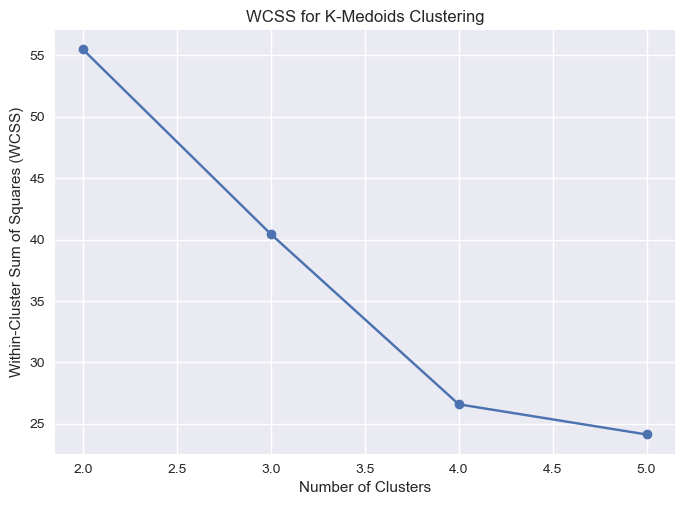

In [57]:
elbow_scr = calculate_elbow_cluster_number(last_forecast_timestep, 2, 5)

In [58]:
def calculate_cluster_number(data, min_clusters, max_clusters, metric='euclidean'):
    """
    Calculates a preferred number of clusters from k-medoids using the silhouette score with a Pandas DataFrame as input.
    Creates a graph to visualize the silhouette scores.
    
    Arguments:
    data -- The input data points as a Pandas DataFrame.
    max_clusters -- The maximum number of clusters to consider.
    metric -- The distance metric to be used (default: 'euclidean').
    
    Returns:
    The preferred number of clusters determined by the silhouette score.
    """
    silhouette_scores = []
    
    for n_clusters in range(min_clusters, max_clusters + 1):
        # Convert the DataFrame to a NumPy array
        data_array = data.values
        
        # Perform k-medoids clustering
        kmedoids = KMedoids(n_clusters=n_clusters, metric=metric)
        labels = kmedoids.fit_predict(data_array)
        
        # Compute the silhouette score
        silhouette_avg = silhouette_score(data_array, labels, metric=metric)
        silhouette_scores.append(silhouette_avg)
    
    # Find the preferred number of clusters based on the maximum silhouette score
    preferred_clusters = np.argmax(silhouette_scores) + min_clusters  # Add min_clusters due to range start
    
    # Create a graph to visualize the silhouette scores
    plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for K-Medoids Clustering')
    plt.show()
    
    return preferred_clusters

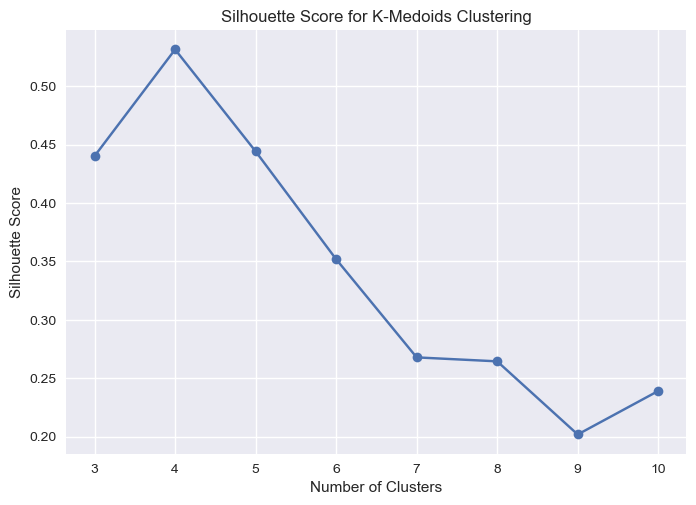

4

In [59]:
silhouette_scr = calculate_cluster_number(last_forecast_timestep, 3, 10)
silhouette_scr

In [60]:
# Either elbow_scr or silhouette_scr
number_clusters = silhouette_scr

In [61]:
cluster_centers_dict = {}

for date in FORECAST_DATES:
    single_forecast_date = df_time.get_group(date)
    p25 = single_forecast_date['temp'].quantile(.25)
    p50 = single_forecast_date['temp'].median()
    p75 = single_forecast_date['temp'].quantile(.75)
    kmedo = KMedoids(n_clusters=number_clusters, random_state=1)
    kmedo.fit(single_forecast_date[['temp']])
    cluster_centers = kmedo.cluster_centers_.flatten()
    cluster_centers = np.append(cluster_centers, [p25, p50, p75])
    
    # Add the cluster centers to the dictionary with the date as the key
    cluster_centers_dict[date] = cluster_centers

# Create a DataFrame from the dictionary
df_cluster_centers = pd.DataFrame.from_dict(cluster_centers_dict, orient='index')
df_cluster_centers = df_cluster_centers.rename_axis('date').reset_index()

# Rename last few columns to add p25, p50, p75
col_names = list(df_cluster_centers.columns)
p25_column = int(col_names[-3])
p50_column = int(col_names[-2])
p75_column = int(col_names[-1])
df_cluster_centers.rename(columns={p25_column: 'p25', p50_column: 'p50', p75_column: 'p75'}, 
                          inplace=True)

df_cluster_centers

,date,0,1,2,3,p25,p50,p75
0,2023-07-31,107.880081,109.312805,106.438072,105.529991,106.055717,106.810066,108.271385
1,2023-08-01,109.006783,111.110008,108.051300,105.170029,108.076900,109.000298,110.302948
2,2023-08-02,108.651100,109.849983,112.010002,106.758873,107.471634,109.544785,110.300037
3,2023-08-03,108.964211,109.698372,112.024178,106.429993,106.610004,108.964211,111.017914
4,2023-08-04,105.893913,108.230270,110.213959,113.101883,106.831848,109.310005,111.187511
5,2023-08-05,112.329430,110.209953,109.726768,107.149986,108.049980,109.926720,111.842381
6,2023-08-06,107.134933,110.975807,104.290245,100.521111,104.096802,107.746758,110.592907
7,2023-08-07,104.857079,109.382072,98.262810,111.900360,101.457058,108.398636,111.424461
8,2023-08-08,106.031685,108.523552,113.506783,98.892715,101.419403,107.149986,109.206707
9,2023-08-09,100.310005,105.318451,109.876572,96.364372,97.995239,103.218193,107.135399


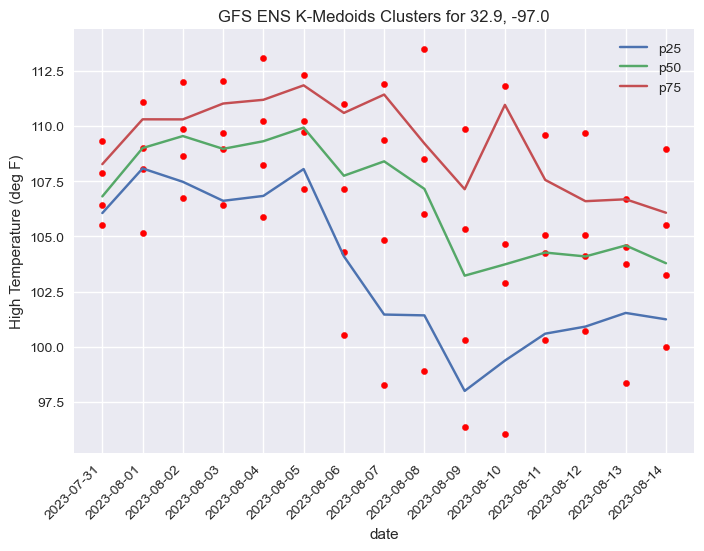

In [62]:
plt.style.use('seaborn-v0_8')
for n in range(0, number_clusters):
    ax = df_cluster_centers.plot.scatter(x='date', y=n, color='red', ax=plt.gca(),
                        title=f'GFS ENS K-Medoids Clusters for {LAT}, {LON}')

df_cluster_centers.plot.line(y='p25', ax=plt.gca())
df_cluster_centers.plot.line(y='p50', ax=plt.gca())
df_cluster_centers.plot.line(y='p75', ax=plt.gca())
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("High Temperature (deg F)")
plt.show()